# kaggle study 19-20일차(Statoil)

코드출처 : https://www.kaggle.com/wvadim/keras-tf-lb-0-18

소개 사실 이것은 저의 첫번째 공용 커널이기 때문에 누군가에게 유용하게 사용되었으면 합니다.

노트북을 읽기 전에 이 노트북이 이미 존재하는 노트북과 일부 모델 수정의 컴파일임을 알아야 합니다. 다음은 노트북 목록입니다.

데이터 분석 - https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python을 
이미지 변환, 네트워크 아키텍처 - https://www.kaggle.com/tivigovidiu/keras-model-for-beginners-0-210-on-lb-eda-r-d입니다.
몇 가지 아이디어 - https://www.kaggle.com/knowledgegrappler/a-keras-prototype-0-21174-on-pl입니다.
매드사이언티스트가 제공한 이미지로 변환하기 위한 코드인데 어떤 커널인지 모르겠습니다.
모델을 실행하기 전에 여기에 언급된 커널을 훑어보고 투표하는 것이 좋습니다.

비고 1080TI로 컴퓨터에서 이 코드를 실행했는데 보급형 GPU 또는 CPU를 사용하는 경우 속도가 상당히 느릴 수 있습니다.

또한 모델 교육 후 케라가 메모리를 확보하지 못하기 때문에 GPU로 노트북에서 코드를 실행하는 방법을 모르는 것이 중요합니다. 따라서 여기서 교육 결과는 불완전할 수 있습니다.

저도 랜덤 시드 초기화에 대해 잘 모르겠고 확인을 못 했으니 아마 저와 결과가 다를 수 있습니다.

또한 10개 이상의 인수가 있는 WinAPI 스타일 기능에는 미안하지만, 이 솔루틴은 하루보다 적게 만들어졌고 기본적으로 나의 두 번째 솔루션이에요. 만약 누군가가 평범한 스타일로 그것을 다시 쓸 수 있다면, 나는 그것을 감사할 것입니다. 그러니 자유롭게 포크를 만들고 다시 쓰세요.

# 1회차

In [2]:
import numpy as np
np.random.seed(98643)
import tensorflow as tf
tf.random.set_seed(683)

# 할당에 대한 TF 경고를 숨기려면 이 설명을 취소해야함
#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 이미지의 종속성을 지우기
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma, denoise_tv_bregman, denoise_nl_means)
from skimage.filters import gaussian
from skimage.color import rgb2gray

# 데이터 읽기 및 시각화
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

# 학습 파트
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, GlobalAveragePooling2D, Lambda
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

# 현재 디렉토리에 작성한 모든 결과는 출력으로 저장됩니다.

먼저, 일부 데이터 사전 처리가 필요합니다.

기본 아이디어는 데이터 세트에 제공된 이미지가 매우 노이즈가 많으며, 세분화된 노이즈를 제거할 경우 자체에서 더 잘 예측하고 노이즈 데이터 세트를 구성할 수 있다는 것입니다.

모델 교육에 추가로 사용될 수 있는 몇 가지 글로벌 기능을 추출하기 위해 데이터 세트에서 노이즈 제거 자동 인코더를 교육하는 것도 흥미롭다.

In [3]:
# 데이터를 이미지 형식으로 변환
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2

        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))

        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

def denoise(X, weight, multichannel):
    return np.asarray([denoise_tv_chambolle(item, weight=weight, multichannel=multichannel) for item in X])

def smooth(X, sigma):
    return np.asarray([gaussian(item, sigma=sigma) for item in X])

def grayscale(X):
    return np.asarray([rgb2gray(item) for item in X])

In [7]:
train = pd.read_json('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/statoil/train.json')
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
train_all = True

# 모델을 보다 효율적으로 교육하기 위해 필요한 train 플래그입니다. 
# 적절한 모델 파라미터를 선택합니다.
train_b = True or train_all
train_img = True or train_all
train_total = True or train_all
predict_submission = True and train_all

clean_all = False
clean_b = False or clean_all
clean_img = False or clean_all

load_all = False
load_b = False or load_all
load_img = False or load_all

In [8]:
def create_dataset(frame, labeled, smooth_rgb=0.2, smooth_gray=0.5,
                   weight_rgb=0.05, weight_gray=0.05):
    band_1, band_2, images = frame['band_1'].values, frame['band_2'].values, color_composite(frame)
    to_arr = lambda x: np.asarray([np.asarray(item) for item in x])
    band_1 = to_arr(band_1)
    band_2 = to_arr(band_2)
    band_3 = (band_1 + band_2) / 2
    gray_reshape = lambda x: np.asarray([item.reshape(75, 75) for item in x])
    # Make a picture format from flat vector
    band_1 = gray_reshape(band_1)
    band_2 = gray_reshape(band_2)
    band_3 = gray_reshape(band_3)
    print('Denoising and reshaping')
    if train_b and clean_b:
        # Smooth and denoise data
        band_1 = smooth(denoise(band_1, weight_gray, False), smooth_gray)
        print('Gray 1 done')
        band_2 = smooth(denoise(band_2, weight_gray, False), smooth_gray)
        print('Gray 2 done')
        band_3 = smooth(denoise(band_3, weight_gray, False), smooth_gray)
        print('Gray 3 done')
    if train_img and clean_img:
        images = smooth(denoise(images, weight_rgb, True), smooth_rgb)
    print('RGB done')
    tf_reshape = lambda x: np.asarray([item.reshape(75, 75, 1) for item in x])
    band_1 = tf_reshape(band_1)
    band_2 = tf_reshape(band_2)
    band_3 = tf_reshape(band_3)
    #images = tf_reshape(images)
    band = np.concatenate([band_1, band_2, band_3], axis=3)
    if labeled:
        y = np.array(frame["is_iceberg"])
    else:
        y = None
    return y, band, images

In [9]:
y_train, X_b, X_images = create_dataset(train, True)

Denoising and reshaping
RGB done


cleaning의 작동 방식을 확인하기 위해 일부 랜덤 이미지를 표시합니다.

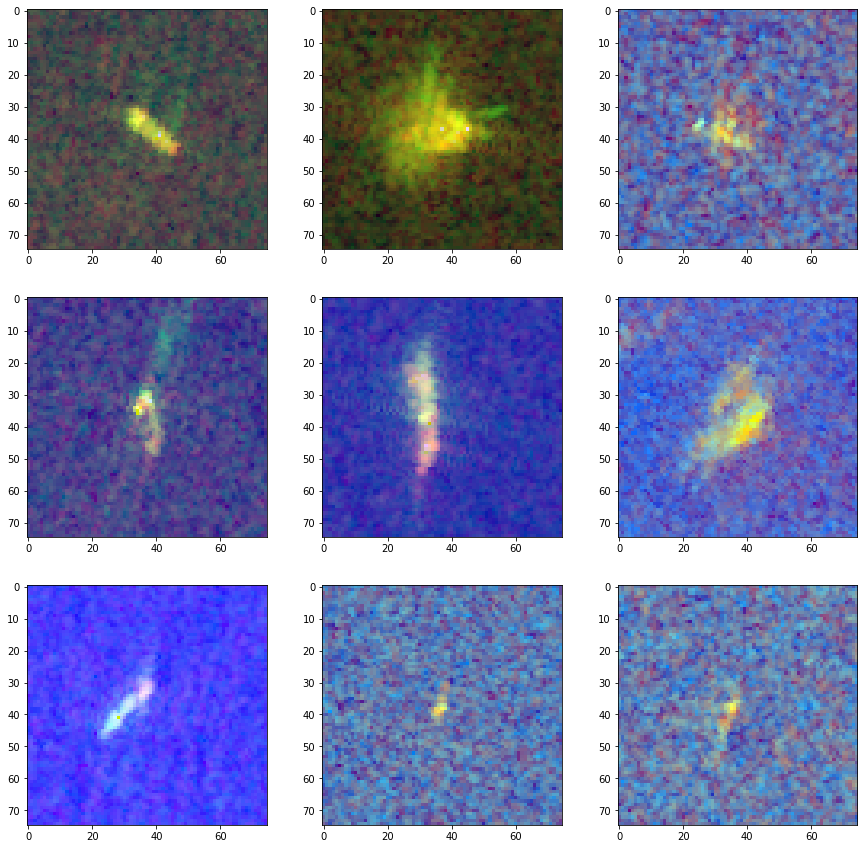

In [10]:
fig = plt.figure(200, figsize=(15, 15))
random_indicies = np.random.choice(range(len(X_images)), 9, False)
subset = X_images[random_indicies]
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

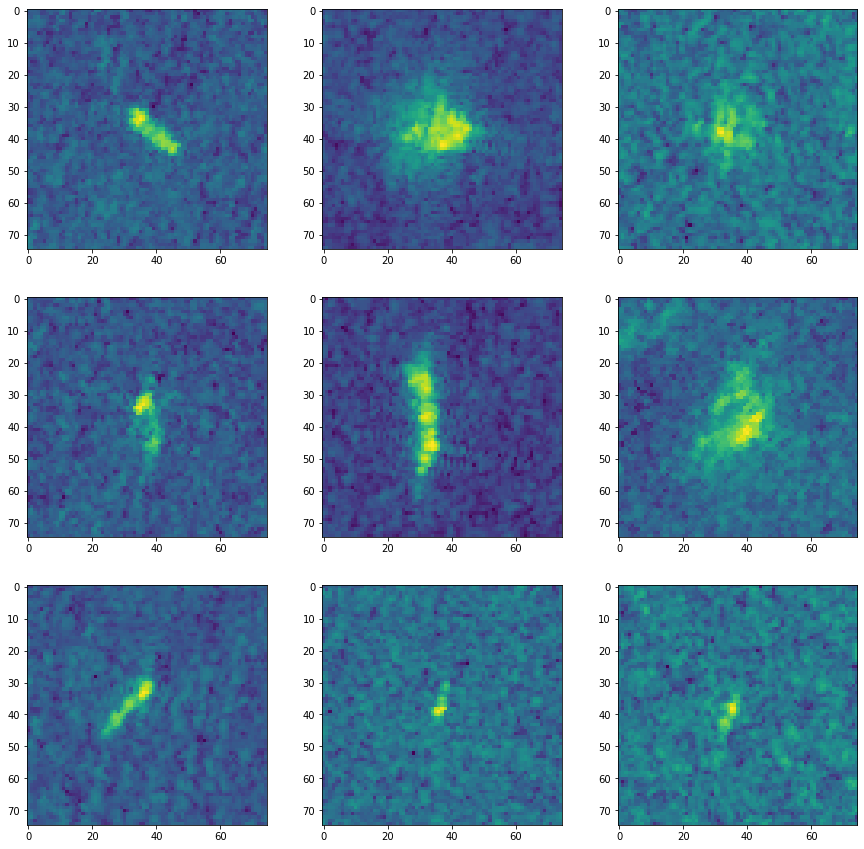

In [11]:
fig = plt.figure(202, figsize=(15, 15))
band_1_x = train['band_1'].values
subset = np.asarray(band_1_x)[random_indicies]
subset = np.asarray([np.asarray(item).reshape(75, 75) for item in subset])
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

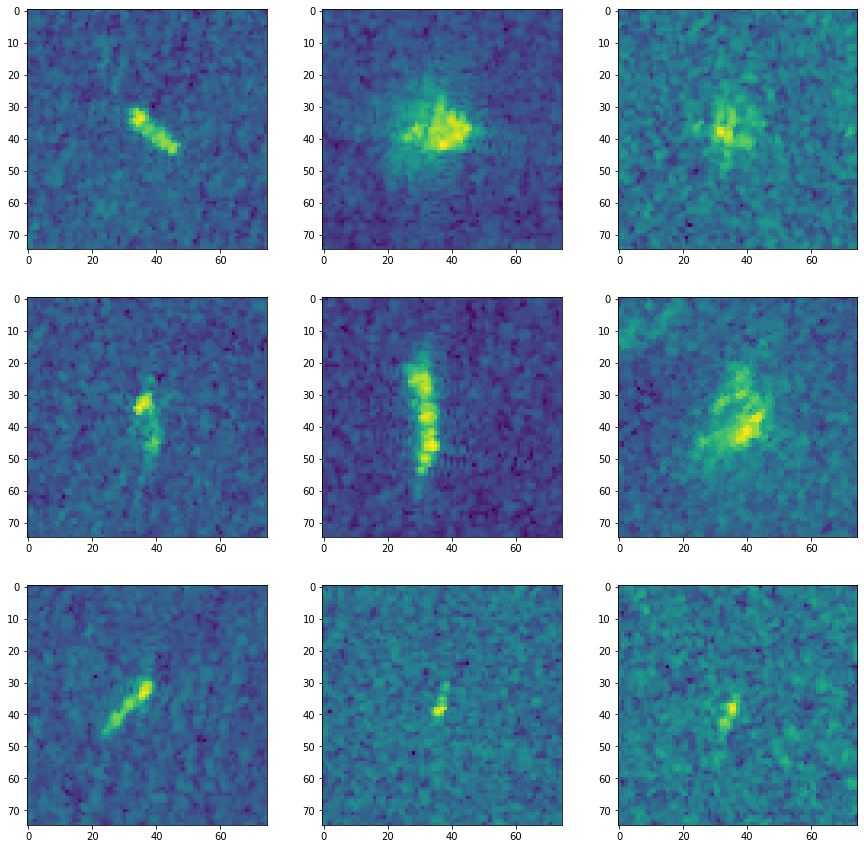

In [12]:
fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indicies]
subset = denoise(np.asarray([np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

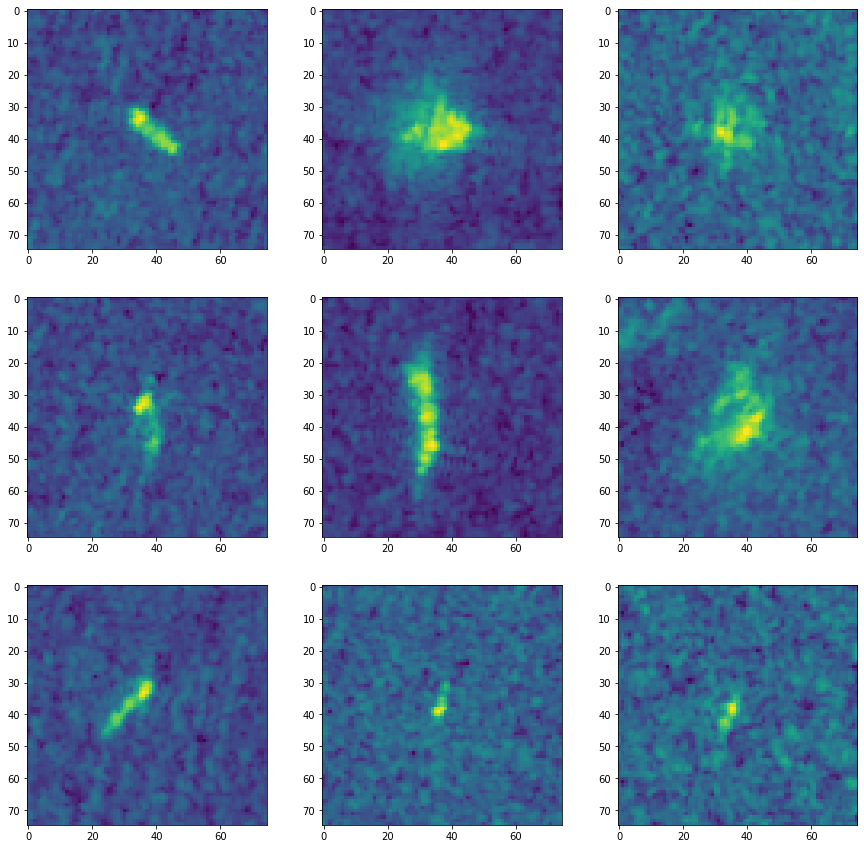

In [13]:
fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indicies]
subset = smooth(denoise(np.asarray(
    [np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False), 0.5)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

#### A few words about model

모델 자체는 3개의 컨볼루션 신경망으로 구성되어 있습니다. 두 개의 기본 네트워크와 한 개의 네트워크가 결합되었습니다. 이 아이디어는 서로 다른 데이터 표현에 대해 두 개의 기본 네트워크를 훈련시키고 그 후에 공통 네트워크를 훈련시키기 위해 훈련된 컨볼루션 레이어를 조합하여 사용하는 것입니다.

이러한 네트워크의 아키텍처는 앞에서 언급한 노트북에서 가져온 것입니다.

3개의 데이터 세트를 사용하는 교육에서는 1개의 네트워크가 한 번만 보고 모델 선택을 위해 기본 연석 분할을 수행합니다.

In [14]:
def get_model_notebook(lr, decay, channels, relu_type='relu'):
    # angle variable은 angle 파라미터를 사용할지 아니면 무시할지를 정의
    input_1 = Input(shape=(75, 75, channels))

    fcnn = Conv2D(32, kernel_size=(3, 3), activation=relu_type)(
        BatchNormalization()(input_1))
    fcnn = MaxPooling2D((3, 3))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(64, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = BatchNormalization()(fcnn)
    fcnn = Flatten()(fcnn)
    local_input = input_1
    partial_model = Model(input_1, fcnn)
    dense = Dropout(0.2)(fcnn)
    dense = Dense(256, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(128, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(64, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    # 어떤 이유에서인지 각도 데이터를 정규화하지 않기로 결정
    output = Dense(1, activation="sigmoid")(dense)
    model = Model(local_input, output)
    optimizer = Adam(lr=lr, decay=decay)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model, partial_model

In [15]:
def combined_model(m_b, m_img, lr, decay):
    input_b = Input(shape=(75, 75, 3))
    input_img = Input(shape=(75, 75, 3))

    # 교육 불가능한 소스 모델을 테스트해 본 적이 없다.
    #for layer in m_b.layers:
    #    layer.trainable = False
    #for layer in m_img.layers:
    #    layer.trainable = False

    m1 = m_b(input_b)
    m2 = m_img(input_img)

    # 따라서 모델을 결합하고 이를 기반으로 퍼셉트론을 훈련함
    # 흥미로운 아이디어는 이 작업에 XGB를 사용하는 것이지만, 필자는 사실 이 방법을 싫어한다고 한다.
    common = Concatenate()([m1, m2])
    common = BatchNormalization()(common)
    common = Dropout(0.3)(common)
    common = Dense(1024, activation='relu')(common)
    common = Dropout(0.3)(common)
    common = Dense(512, activation='relu')(common)
    common = Dropout(0.3)(common)
    output = Dense(1, activation="sigmoid")(common)
    model = Model([input_b, input_img], output)
    optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [16]:
def gen_flow_multi_inputs(I1, I2, y, batch_size):
    gen1 = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.,
                             height_shift_range=0.,
                             channel_shift_range=0,
                             zoom_range=0.2,
                             rotation_range=10)
    gen2 = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.,
                             height_shift_range=0.,
                             channel_shift_range=0,
                             zoom_range=0.2,
                             rotation_range=10)
    genI1 = gen1.flow(I1, y, batch_size=batch_size, seed=57, shuffle=False)
    genI2 = gen2.flow(I1, I2, batch_size=batch_size, seed=57, shuffle=False)
    while True:
        I1i = genI1.next()
        I2i = genI2.next()
        #print I1i[0].shape
        np.testing.assert_array_equal(I2i[0], I1i[0])
        yield [I1i[0], I2i[1]], I1i[1]

In [17]:
def train_model(model, batch_size, epochs, checkpoint_name, X_train, y_train, val_data, verbose=2):
    callbacks = [ModelCheckpoint(checkpoint_name, save_best_only=True, monitor='val_loss')]
    datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.,
                                   height_shift_range=0.,
                                   channel_shift_range=0,
                                   zoom_range=0.2,
                                   rotation_range=10)
    x_test, y_test = val_data
    try:
        model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs,
                                    steps_per_epoch=len(X_train) / batch_size,
                                    validation_data=(x_test, y_test), verbose=1,
                                    callbacks=callbacks)
    except KeyboardInterrupt:
        if verbose > 0:
            print('Interrupted')
    if verbose > 0:
        print('Loading model')
    model.load_weights(filepath=checkpoint_name)
    return model

In [18]:
#특정 모델을 교육
def gen_model_weights(lr, decay, channels, relu, batch_size, epochs, path_name, data, verbose=2):
    X_train, y_train, X_test, y_test, X_val, y_val = data
    model, partial_model = get_model_notebook(lr, decay, channels, relu)
    model = train_model(model, batch_size, epochs, path_name,
                           X_train, y_train, (X_test, y_test), verbose=verbose)

    if verbose > 0:
        loss_val, acc_val = model.evaluate(X_val, y_val,
                               verbose=0, batch_size=batch_size)

        loss_train, acc_train = model.evaluate(X_test, y_test,
                                       verbose=0, batch_size=batch_size)

        print('Val/Train Loss:', str(loss_val) + '/' + str(loss_train), \
            'Val/Train Acc:', str(acc_val) + '/' + str(acc_train))
    return model, partial_model

In [19]:
# 3가지 모델을 모두 교육
def train_models(dataset, lr, batch_size, max_epoch, verbose=2, return_model=False):
    y_train, X_b, X_images = dataset
    y_train_full, y_val,\
    X_b_full, X_b_val,\
    X_images_full, X_images_val = train_test_split(y_train, X_b, X_images, random_state=687, train_size=0.9)

    y_train, y_test, \
    X_b_train, X_b_test, \
    X_images_train, X_images_test = train_test_split(y_train_full, X_b_full, X_images_full, random_state=576, train_size=0.85)

    if train_b:
        if verbose > 0:
            print('Training bandwidth network')
        data_b1 = (X_b_train, y_train, X_b_test, y_test, X_b_val, y_val)
        model_b, model_b_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_b',
                                                 data=data_b1, verbose=verbose)

    if train_img:
        if verbose > 0:
            print('Training image network')
        data_images = (X_images_train, y_train, X_images_test, y_test, X_images_val, y_val)
        model_images, model_images_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_img',
                                                       data_images, verbose=verbose)

    if train_total:
        common_model = combined_model(model_b_cut, model_images_cut, lr/2, 1e-7)
        common_x_train = [X_b_full, X_images_full]
        common_y_train = y_train_full
        common_x_val = [X_b_val, X_images_val]
        common_y_val = y_val
        if verbose > 0:
            print('Training common network')
        callbacks = [ModelCheckpoint('common', save_best_only=True, monitor='val_loss')]
        try:
            common_model.fit_generator(gen_flow_multi_inputs(X_b_full, X_images_full, y_train_full, batch_size),
                                         epochs=30,
                                  steps_per_epoch=len(X_b_full) / batch_size,
                                  validation_data=(common_x_val, common_y_val), verbose=1,
                                  callbacks=callbacks)
        except KeyboardInterrupt:
            pass
        common_model.load_weights(filepath='common')
        loss_val, acc_val = common_model.evaluate(common_x_val, common_y_val,
                                           verbose=0, batch_size=batch_size)
        loss_train, acc_train = common_model.evaluate(common_x_train, common_y_train,
                                                  verbose=0, batch_size=batch_size)
        if verbose > 0:
            print('Loss:', loss_val, 'Acc:', acc_val)
    if return_model:
        return common_model
    else:
        return (loss_train, acc_train), (loss_val, acc_val)

교육에 사용되는 모델 매개 변수는 모든 데이터를 처리할 수 있는 계산 능력이 충분하다고 가정합니다.

(명확한 것인지 아닌지 알 수 없습니다.) 여기서 중요한 것은 검증 세트를 기준으로 모델을 선택하는 경우 검증 세트를 잘못 관측하게 되고 최종 평가 점수에 영향을 미치기 때문에 최종 성능에 영향을 미치기 때문에 3개의 세트를 저장하는 것입니다.

In [21]:
# 가장 좋은 매개 변수는 다음과 같습니다.
# epochs : 250
# learning rate : 8e-5
# batch size : 32
common_model = train_models((y_train, X_b, X_images), 7e-04, 32, 50, 1, return_model=True)

Training bandwidth network


C:\Users\이동훈\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
38/38 [==============================] - 21s 494ms/step - loss: 0.6654 - accuracy: 0.5709 - val_loss: 3.3475 - val_accuracy: 0.5253
INFO:tensorflow:Assets written to: model_b\assets
Epoch 2/50
38/38 [==============================] - 6s 145ms/step - loss: 0.5894 - accuracy: 0.6654 - val_loss: 1.9036 - val_accuracy: 0.5253
INFO:tensorflow:Assets written to: model_b\assets
Epoch 3/50
38/38 [==============================] - 6s 145ms/step - loss: 0.6080 - accuracy: 0.6607 - val_loss: 0.7590 - val_accuracy: 0.5253
INFO:tensorflow:Assets written to: model_b\assets
Epoch 4/50
38/38 [==============================] - 6s 142ms/step - loss: 0.5595 - accuracy: 0.6956 - val_loss: 0.5863 - val_accuracy: 0.6498
INFO:tensorflow:Assets written to: model_b\assets
Epoch 5/50
38/38 [==============================] - 6s 142ms/step - loss: 0.5014 - accuracy: 0.7698 - val_loss: 0.6349 - val_accuracy: 0.5945
Epoch 6/50
38/38 [==============================] - 5s 139ms/step - loss: 0.4801 - accura

OpError: 

In [23]:
if predict_submission:
    print('Reading test dataset')
    test = pd.read_json('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/statoil/test.json')
    y_fin, X_fin_b, X_fin_img = create_dataset(test, False)
    print('Predicting')
    prediction = common_model.predict([X_fin_b, X_fin_img], verbose=1, batch_size=32)
    print('Submitting')
    submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})

    submission.to_csv("./submission.csv", index=False)
    print('Done')

Reading test dataset
Denoising and reshaping
RGB done
Predicting


NameError: name 'common_model' is not defined

# 2회차

In [24]:
import numpy as np
np.random.seed(98643)
import tensorflow as tf
tf.random.set_seed(683)

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma, denoise_tv_bregman, denoise_nl_means)
from skimage.filters import gaussian
from skimage.color import rgb2gray

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, GlobalAveragePooling2D, Lambda
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

먼저, 일부 데이터 사전 처리가 필요합니다.

기본 아이디어는 데이터 세트에 제공된 이미지가 매우 노이즈가 많으며, 세분화된 노이즈를 제거할 경우 자체에서 더 잘 예측하고 노이즈 데이터 세트를 구성할 수 있다는 것입니다.

모델 교육에 추가로 사용될 수 있는 몇 가지 글로벌 기능을 추출하기 위해 데이터 세트에서 노이즈 제거 자동 인코더를 교육하는 것도 흥미롭다.

In [25]:
def color_composite(data):
    rgb_arrays = []
    for i,row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75,75)
        band_2 = np.array(row['band_2']).reshape(75,75)
        band_3 = band_1 / band_2
        
        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))
        
        rgb = np.dstack((r,g,b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

def denoise(X,weight,multichannel):
    return np.asarray([denoise_tv_chambolle(item,weight=weight,multichannel=multichannel)for item in X])

def smooth(X, sigma):
    return np.asarray([gaussian(item, sigma=sigma) for item in X])

def grayscale(X):
    return np.asarray([rgb2gray(item) for item in X])

In [26]:
train = pd.read_json('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/statoil/train.json')
train.inc_angle = train.inc_angle.replace('na',0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)

train_b = True or train_all
train_img = True or train_all
train_total = True or train_all
predict_submission = True or train_all

clean_all = False
clean_b = False or clean_all
clean_img = False or clean_all

load_all = False
load_b = False or load_all
load_img = False or load_all

In [29]:
def create_dataset(frame,labeled,smooth_rgb=0.2,smooth_gray=0.5,
                  weight_rgb=0.05,weight_gray=0.05):
    band_1,band_2,images=frame['band_1'].values,frame['band_2'].values,color_composite(frame)
    to_arr = lambda x: np.asarray([np.asarray(item)for item in x])
    band_1 = to_arr(band_1)
    band_2 = to_arr(band_2)
    band_3 = (band_1+band_2)/2
    gray_reshape = lambda x: np.asarray([item.reshape(75,75)for item in x])
    
    band_1 = gray_reshape(band_1)
    band_2 = gray_reshape(band_2)
    band_3 = gray_reshape(band_3)
    print('Denoising and reshaping')
    if train_b and clean_b:
        band_1 = smoothing(denoise(band_1,weight_gray,False),smooth_gray)
        print('Gray 1 done')
        band_2 = smoothing(denoise(band_2,weight_gray,False),smooth_gray)
        print('Gray 2 done')
        band_3 = smoothing(denoise(band_3,weight_gray,False),smooth_gray)
        print('Gray 3 done')
    if train_img and clean_img:
        images = smoothing(denoise(imanges,weight_rgb,True),smooth_rgb)
        print('RGB done')
    tf_reshape = lambda x: np.asarray([item.reshape(75,75,1)for item in x])
    band_1 = tf_reshape(band_1)
    band_2 = tf_reshape(band_2)
    band_3 = tf_reshape(band_3)
    
    band = np.concatenate([band_1,band_2,band_3],axis=3)
    if labeled:
        y = np.array(frame['is_iceberg'])

    else:
        y = None
    return y,band,images    

In [30]:
y_train, X_b, X_images = create_dataset(train, True)

Denoising and reshaping


cleaning의 작동 방식을 확인하기 위해 일부 랜덤 이미지를 표시합니다.

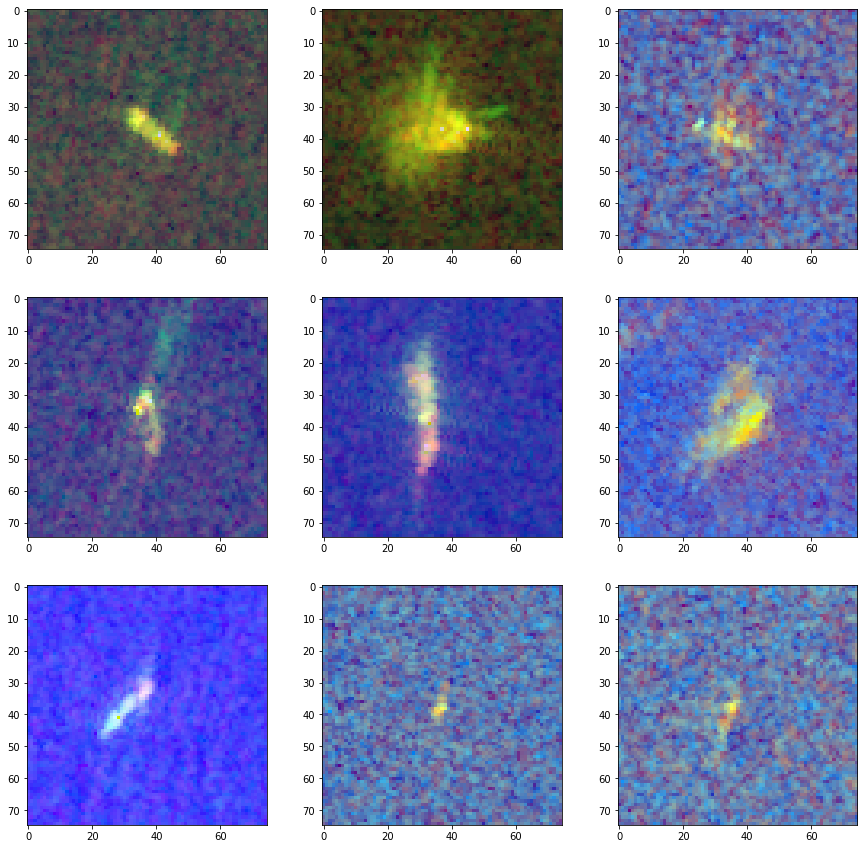

In [31]:
fig = plt.figure(200, figsize=(15, 15))
random_indicies = np.random.choice(range(len(X_images)), 9, False)
subset = X_images[random_indicies]
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

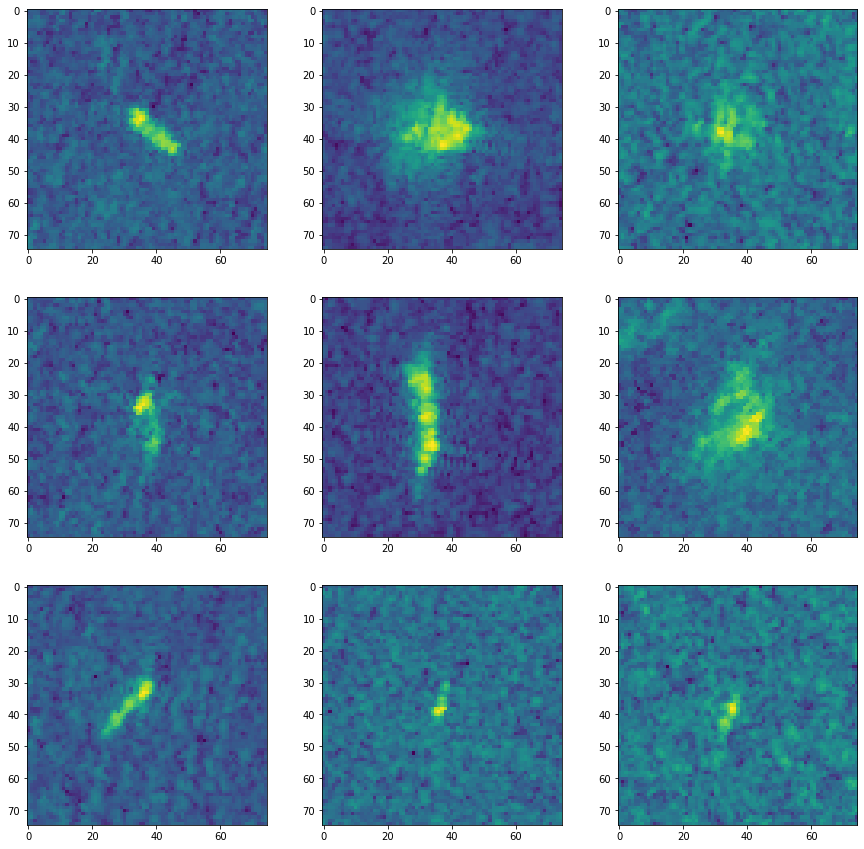

In [32]:
fig = plt.figure(202, figsize=(15, 15))
band_1_x = train['band_1'].values
subset = np.asarray(band_1_x)[random_indicies]
subset = np.asarray([np.asarray(item).reshape(75,75) for item in subset])
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

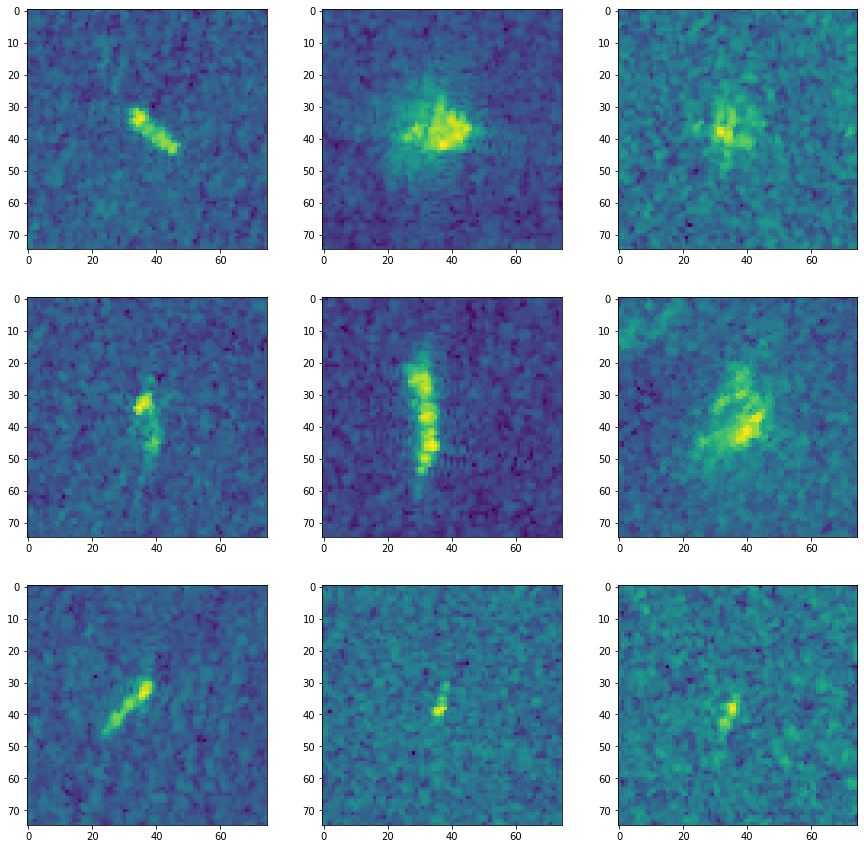

In [33]:
fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indicies]
subset = denoise(np.asarray([np.asarray(item).reshape(75,75) for item in subset]),0.05,False)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

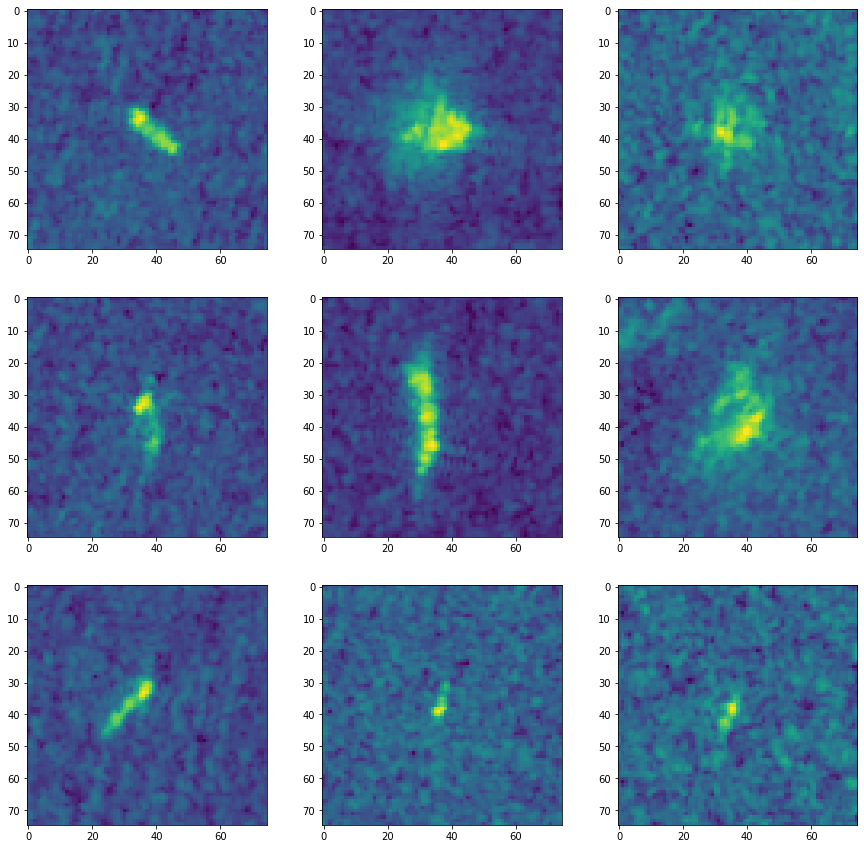

In [34]:
fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indicies]
subset = smooth(denoise(np.asarray([np.asarray(item).reshape(75,75) for item in subset]),0.05,False),0.5)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

#### A few words about model

모델 자체는 3개의 컨볼루션 신경망으로 구성되어 있습니다. 두 개의 기본 네트워크와 한 개의 네트워크가 결합되었습니다. 이 아이디어는 서로 다른 데이터 표현에 대해 두 개의 기본 네트워크를 훈련시키고 그 후에 공통 네트워크를 훈련시키기 위해 훈련된 컨볼루션 레이어를 조합하여 사용하는 것입니다.

이러한 네트워크의 아키텍처는 앞에서 언급한 노트북에서 가져온 것입니다.

3개의 데이터 세트를 사용하는 교육에서는 1개의 네트워크가 한 번만 보고 모델 선택을 위해 기본 연석 분할을 수행합니다.

In [48]:
def get_model_notebook(lr,decay,channels,relu_type='relu'):
    input_1 = Input(shape=(75,75,channels))
    
    fcnn = Conv2D(32,kernel_size=(3,3),activation=relu_type)(BatchNormalization()(input_1))
    fcnn = MaxPooling2D((3,3))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(64,kernel_size=(3,3),activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2,2),strides=(2,2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128,kernel_size=(3,3),activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2,2),strides=(2,2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128,kernel_size=(3,3),activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2,2),strides=(2,2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = BatchNormalization()(fcnn)
    fcnn = Flatten()(fcnn)
    local_input = input_1
    partial_model = Model(input_1,fcnn)
    dense = Dropout(0.2)(fcnn)
    dense = Dense(256,activation = relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(128,activation = relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(64,activation = relu_type)(dense)
    dense = Dropout(0.2)(dense)
    
    output = Dense(1,activation = 'sigmoid')(dense)
    model = Model(local_input,output)
    optimizer = Adam(lr=lr,decay=decay)
    model.compile(loss='binary_crossentropy',optimizer = optimizer, metrics=["accuracy"])
    return model, partial_model

In [37]:
def combined_model(m_b, m_img, lr, decay):
    input_b = Input(shape=(75, 75, 3))
    input_img = Input(shape=(75, 75, 3))

    m1 = m_b(input_b)
    m2 = m_img(input_img)

    common = Concatenate()([m1, m2])
    common = BatchNormalization()(common)
    common = Dropout(0.3)(common)
    common = Dense(1024, activation='relu')(common)
    common = Dropout(0.3)(common)
    common = Dense(512, activation='relu')(common)
    common = Dropout(0.3)(common)
    output = Dense(1, activation="sigmoid")(common)
    model = Model([input_b, input_img], output)
    optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [38]:
def gen_flow_multi_inputs(I1, I2, y, batch_size):
    gen1 = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,
                              width_shift_range=0.,height_shift_range=0.,
                              channel_shift_range=0,zoom_range=0.2,rotation_range=10)
    gen2 = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,
                              width_shift_range=0.,height_shift_range=0.,
                              channel_shift_range=0,zoom_range=0.2,rotation_range=10)
    genI1 = gen1.flow(I1, y, batch_size=batch_size, seed=57, shuffle=False)
    genI2 = gen2.flow(I1, I2, batch_size=batch_size, seed=57, shuffle=False)
    while True:
        I1i = genI1.next()
        I2i = genI2.next()
        np.testing.assert_array_equal(I2i[0], I1i[0])
        yield [I1i[0], I2i[1]], I1i[1]

In [40]:
def train_model(model, batch_size, epochs, checkpoint_name, X_train, y_train, val_data, verbose=2):
    callbacks = [ModelCheckpoint(checkpoint_name,save_best_only=True,monitor='val_loss')]
    datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,
                              width_shift_range=0.,height_shift_range=0.,
                              channel_shift_range=0,zoom_range=0.2,rotation_range=10)
    x_test,y_test = val_data
    try:
        model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs,
                                        steps_per_epoch=len(X_train) / batch_size,
                                        validation_data=(x_test, y_test), verbose=1,
                                        callbacks=callbacks)
    except KeyboardInterrupt:
        if verbose > 0:
            print('Interrupted')
    if verbose > 0:
        print('Loading model')
    model.load_weights(filepath=checkpoint_name)
    return model

In [41]:
def gen_model_weights(lr, decay, channels, relu, batch_size, epochs, path_name, data, verbose=2):
    X_train, y_train, X_test, y_test, X_val, y_val = data
    model, partial_model = get_model_notebook(lr, decay, channels, relu)
    model = train_model(model, batch_size, epochs, path_name,X_train, y_train, (X_test, y_test), verbose=verbose)

    if verbose > 0:
        loss_val, acc_val = model.evaluate(X_val, y_val,verbose=0, batch_size=batch_size)
        loss_train, acc_train = model.evaluate(X_test, y_test,verbose=0, batch_size=batch_size)
        print('Val/Train Loss:', str(loss_val) + '/' + str(loss_train), 'Val/Train Acc:', str(acc_val) + '/' + str(acc_train))
    return model, partial_model

In [42]:
def train_models(dataset, lr, batch_size, max_epoch, verbose=2, return_model=False):
    y_train, X_b, X_images = dataset
    y_train_full, y_val,\
    X_b_full, X_b_val,\
    X_images_full, X_images_val = train_test_split(y_train, X_b, X_images, random_state=687, train_size=0.9)

    y_train, y_test, \
    X_b_train, X_b_test, \
    X_images_train, X_images_test = train_test_split(y_train_full, X_b_full, X_images_full, random_state=576, train_size=0.85)

    if train_b:
        if verbose > 0:
            print('Training bandwidth network')
        data_b1 = (X_b_train, y_train, X_b_test, y_test, X_b_val, y_val)
        model_b, model_b_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_b',
                                                 data=data_b1, verbose=verbose)

    if train_img:
        if verbose > 0:
            print('Training image network')
        data_images = (X_images_train, y_train, X_images_test, y_test, X_images_val, y_val)
        model_images, model_images_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_img',
                                                       data_images, verbose=verbose)

    if train_total:
        common_model = combined_model(model_b_cut, model_images_cut, lr/2, 1e-7)
        common_x_train = [X_b_full, X_images_full]
        common_y_train = y_train_full
        common_x_val = [X_b_val, X_images_val]
        common_y_val = y_val
        if verbose > 0:
            print('Training common network')
        callbacks = [ModelCheckpoint('common', save_best_only=True, monitor='val_loss')]
        try:
            common_model.fit_generator(gen_flow_multi_inputs(X_b_full, X_images_full, y_train_full, batch_size),
                                         epochs=30,
                                  steps_per_epoch=len(X_b_full) / batch_size,
                                  validation_data=(common_x_val, common_y_val), verbose=1,
                                  callbacks=callbacks)
        except KeyboardInterrupt:
            pass
        common_model.load_weights(filepath='common')
        loss_val, acc_val = common_model.evaluate(common_x_val, common_y_val,
                                           verbose=0, batch_size=batch_size)
        loss_train, acc_train = common_model.evaluate(common_x_train, common_y_train,
                                                  verbose=0, batch_size=batch_size)
        if verbose > 0:
            print('Loss:', loss_val, 'Acc:', acc_val)
    if return_model:
        return common_model
    else:
        return (loss_train, acc_train), (loss_val, acc_val)

In [49]:
common_model = train_models((y_train, X_b, X_images), 7e-04, 32, 50, 1, return_model=True)

Training bandwidth network


C:\Users\이동훈\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
38/38 [==============================] - 10s 184ms/step - loss: 0.6821 - accuracy: 0.5567 - val_loss: 2.8792 - val_accuracy: 0.5253
INFO:tensorflow:Assets written to: model_b\assets
Epoch 2/50
38/38 [==============================] - 7s 187ms/step - loss: 0.6168 - accuracy: 0.6406 - val_loss: 1.3731 - val_accuracy: 0.5253
INFO:tensorflow:Assets written to: model_b\assets
Epoch 3/50
38/38 [==============================] - 6s 151ms/step - loss: 0.5958 - accuracy: 0.6865 - val_loss: 0.6402 - val_accuracy: 0.5530
INFO:tensorflow:Assets written to: model_b\assets
Epoch 4/50
38/38 [==============================] - 6s 146ms/step - loss: 0.5852 - accuracy: 0.6856 - val_loss: 0.5851 - val_accuracy: 0.6590
INFO:tensorflow:Assets written to: model_b\assets
Epoch 5/50
38/38 [==============================] - 7s 189ms/step - loss: 0.5034 - accuracy: 0.7313 - val_loss: 0.6393 - val_accuracy: 0.6313
Epoch 6/50
38/38 [==============================] - 6s 165ms/step - loss: 0.5122 - accura

OpError: 

In [50]:
if predict_submission:
    print('Reading test dataset')
    test = pd.read_json('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/statoil/test.json')
    y_fin, X_fin_b, X_fin_img = create_dataset(test, False)
    print('Predicting')
    prediction = common_model.predict([X_fin_b, X_fin_img], verbose=1, batch_size=32)
    print('Submitting')
    submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})

    submission.to_csv("./submission.csv", index=False)
    print('Done')

Reading test dataset


ValueError: Could not reserve memory block